In [27]:
import sys; sys.path.insert(0, '..')

import gym
import sys
import torch
import tester
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

from pytorch_drl.envs.bit_flip import BitFlipping
from pytorch_drl.algs.her import HER

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#
#device = "cpu"
print("Device:", device)


Device: cuda:0


## 1. Define Utils:

### 1.1 Plotting:

In [3]:
def mean_filter(arr, filter_len):
    arr = np.concatenate([[arr[0]]*(filter_len-1), arr])
    filter_arr = np.ones(filter_len)/filter_len
    arr = arr
    output = list()
    for i in range(filter_len-1, len(arr)):
        conv = np.sum(filter_arr * arr[i-filter_len+1:i+1])
        output.append(conv)
    return output

def plot(scores, n=None):
    if n is not None:
        scores = mean_filter(scores, n)
    clear_output(True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

## 2. Create environment

In [63]:
num_bits = 15
env = BitFlipping(num_bits)
env.seed(0)

state_size =  env.observation_space.shape[0]
s, g = env.reset()
print("State size:", s.shape, "\tGoal size:", g.shape)

action_size = env.action_space.n

network_input_shape = np.concatenate([s, g], axis=-1).shape
print("inp size:", network_input_shape)

State size: (15,) 	Goal size: (15,)
inp size: (30,)


## 3. HER + DQN Test



In [64]:
import pytorch_drl.models.rainbow_models as models
from pytorch_drl.algs.rainbow import Rainbow
network_input_shape = np.concatenate([s, g], axis=-1).shape[0]

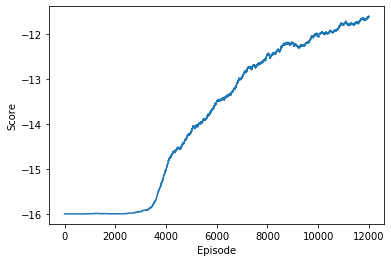

In [93]:
dqn_model1 = models.DQNNetwork(network_input_shape, action_size, H=512)
dqn_model2 = models.DQNNetwork(network_input_shape, action_size, H=512)
dqn_model2.load_state_dict(dqn_model1.state_dict())

alg_constr = Rainbow
alg_args = (network_input_shape, action_size, 0)
alg_kwargs=dict(
             ddqn = True,
             model1 = dqn_model1,
             model2 = dqn_model2,
             gamma = 0.99,
             buf_size = int(1e5),
             batch_size = 64,
             tau = 1e-3,
             device = device
)

agent = HER(env, alg_constr, alg_args, alg_kwargs)
n_episodes = 12_000
scores = agent.train(n_episodes, t_max=num_bits+5, n_epochs=1, max_score=0, strategy='next')
# plot the training:
plot(scores, n=500)

## HER + DDPG for a Continuous Task

In [17]:
# Puck push env
# TODO
env_id = ""

In [ ]:
value_net_constructor = models.DDPGValueNetwork
value_net_args = (state_size, action_size, 256, 256)

policy_net_constructor = models.DDPGPolicyNetwork
policy_net_args = (state_size, action_size, 256, 256)

max_act = env.action_space.high
min_act = env.action_space.low

noise_proc = Gaussian(x_size=env.action_space.shape, 
                      mu=0., sigma_init=0.1, sigma_final=1, 
                      sigma_horizon=1)

action = env.action_space.sample()
lr_val = 1e-3
lr_pol = 1e-3

alg_constr = TD3
alg_args = (policy_net_constructor=policy_net_constructor,
            policy_net_args=policy_net_args,
            value_net_constructor=value_net_constructor,
            value_net_args=value_net_args,
            policy_noise=0.2,
            noise_clip=0.5,
            gamma=0.99, 
            lr_val=lr_val,
            lr_pol=lr_pol,
            prioritized_replay=False,
            is_beta=0.6,
            beta_horz=10e5,
            pr_alpha=0.0,
            buf_size=int(1e6),
            batch_size=128,
            tau=1e-2,
            device=device,
            normalize_rewards=False,
            max_grad_norm=0.5,
            n=1,
            nstep=False,
            min_act=min_act,
            max_act=max_act,
            warm_up=1e4,
            noise_process=noise_proc,
            update_interval=2,
            seed=0
                )

# TODO
td3_her = HER(env_id, alg_constr, alg_args)

# ...